## Baseline for Slot1

## Check dataset existence

In [1]:
# check data existence
from pathlib import Path


data_folder = Path.cwd().parent.joinpath("data/processed")

def check_data_existence(folder):
    file_count = len(list(folder.glob("e*_ann.json")))
    if  file_count == 0:
        raise Exception("Processed Data does not exist.")
    else:
        print("{} files exist.".format(file_count))


check_data_existence(data_folder)

230 files exist.


## Read Slot1 data to DataFrame

Basic strategy

* Predict the attribute from sentence. Because attribute keywords not


In [2]:
# Slot1 predicts E#A label from entity and sentence
import json
import pandas as pd
from collections import Counter
from janome.tokenizer import Tokenizer


dataset = []
corpus = []
word_freq = Counter()
tokenizer = Tokenizer()
PAD = "__PAD__"
UNK = "__UNK__"


def format_word(word):
    if word.isdigit():
        return "0"
    else:
        return word.strip()


def tokenize(sentence, register=True):
    tokens = tokenizer.tokenize(sentence)
    words = []
    for t in tokens:
        pos = t.part_of_speech.split(",")
        if pos[0] == "名詞" or pos[1].startswith("括弧"):
            w = format_word(t.surface) 
            if w:
                words.append(w)
                if register:
                    word_freq[w] += 1
    return words
    

for f in data_folder.glob("e*_ann.json"):
    with f.open(encoding="utf-8") as j:
        d = json.load(j)        
        for s in d["sentences"]:
            # register words
            tokenized = tokenize(s["sentence"])
            corpus.append(tokenized)

            for o in s["opinions"]:
                targets = tokenize(o["target"])
                for t in targets:
                    d = {
                        "label": o["category"],
                        "target": t,
                        "context": [_t for _t in targets if _t != t],
                        "entity": o["category"].split("#")[0],
                        "attribute": o["category"].split("#")[1],
                        "corpus_index": len(corpus) -1
                    }
                    dataset.append(d)

In [3]:
%matplotlib inline

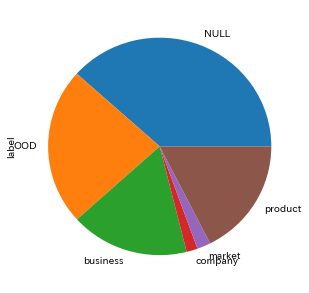

In [4]:
dataset = pd.DataFrame(dataset)
dataset.tail(5)
dataset.groupby("entity").count()["label"].plot.pie(figsize=(5, 5))

In [5]:
dataset.groupby("label").count()["target"].sort_values(ascending=False)

label
OOD#general         3934
NULL#profit         2672
NULL#sales          2115
business#sales      1395
product#amount      1354
product#sales        888
NULL#cost            760
NULL#amount          722
product#general      624
business#profit      620
business#amount      379
business#general     359
market#general       332
NULL#price           176
company#sales         91
business#cost         83
company#amount        71
company#profit        61
business#price        53
product#price         52
company#general       37
product#profit        21
company#cost          11
product#cost          10
NULL#general           5
Name: target, dtype: int64

In [6]:
# Filter NULL / OOD entity
dataset = dataset[(dataset["entity"] != "NULL") & (dataset["entity"] != "OOD")]

In [7]:
# reset index from 0    
dataset.reset_index(drop=True, inplace=True)
# show dataset size
print("{} data is available.".format(len(dataset)))

6441 data is available.


In [8]:
dataset.head(5)

,attribute,context,corpus_index,entity,label,target
0,general,[業界],2,market,market#general,歯科
1,general,[歯科],2,market,market#general,業界
2,sales,[品],12,product,product#sales,化工
3,sales,[化工],12,product,product#sales,品
4,sales,"[/, ＣＡＭ, 関連, 製品]",12,product,product#sales,ＣＡＤ


In [9]:
print(corpus[12])

['これら', '製品', '当社', '注力', '分野', '化工', '品', 'ＣＡＤ', '/', 'ＣＡＭ', '関連', '製品', '売上', '寄与', '市場', '競争', '激化', '人工', '歯', 'はじめ', '既存', '主力', '製品', '販売', '計画', '前年', '同期', '比', '減収']


In [10]:
vocab = [PAD, UNK]
max_vocab = 5000

for term, freq in word_freq.most_common():
    if len(vocab) < max_vocab:
        vocab.append(term)
        
print("Vocabulary size is {} / {}.".format(len(vocab), len(word_freq)))

Vocabulary size is 5000 / 7367.


## Prepare the word vector

In [11]:
# check pretrained vector existence
EMBED_SIZE = 300  # fastText is 300dim
word_vector_path = Path.cwd().joinpath("wiki.ja.vec")
if not word_vector_path.exists():
    raise Exception("Pre-trained word vector is not downloaded. Please execute download_fast_text.py.")

In [12]:
import numpy as np


embedding_matrix = np.zeros((len(vocab), EMBED_SIZE)) 

hit_count = -1
with word_vector_path.open(encoding="utf-8") as f:
    for line in f:
        if hit_count == -1:
            hit_count = 0
            continue  # skip first line that has (vocab_size, vector_size)

        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        if word in vocab:
            hit_count += 1
            index = vocab.index(word)
            embedding_matrix[index] = vector

print("load word embeddings ({} / {} is loaded).".format(hit_count, len(vocab)))

load word embeddings (4219 / 5000 is loaded).


## Make Baseline Model

* Baseline Model predicts the entity and attribute separately.
* After each prediction is done, concatenate these.


In [28]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


class SentenceTfidf(BaseEstimator, TransformerMixin):
    
    def __init__(self, corpus, vocab):
        # corpus includes train/test sentences
        # fit is executed under train data indices, and tranform is done under test ones.
        self.corpus = corpus
        self.vocab = vocab
        self.vectorizer = TfidfVectorizer(vocabulary=self.vocab)
    
    def fit(self, X, y=None):
        indices = X["corpus_index"].tolist()
        texts = [self._format_text(i) for i in indices]
        self.vectorizer.fit(texts)
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)
    
    def _format_text(self, i):
        s = self.corpus[i]
        s = [UNK if w not in vocab else w for w in s]
        text = " ".join(s)
        return text

    def transform(self, X, copy=True):
        indices = X["corpus_index"].tolist()
        texts = [self._format_text(i) for i in indices]
        return self.vectorizer.transform(texts, copy)


class WordToVector(BaseEstimator, TransformerMixin):
    
    def __init__(self, vocab, embeddings):
        self.vocab = vocab
        self.embeddings = embeddings
    
    def fit(self, X, y=None):
        pass
    
    def fit_transform(self, X, y=None):
        return self.transform(X)
    
    def transform(self, X, copy=True):
        def vectorize(w):
            v = np.random.uniform(0, 1, self.embeddings.shape[1])
            if  w in self.vocab:
                v = self.embeddings[self.vocab.index(w)]
            return v
        
        def merge(ws):
            if len(ws) == 0:
                return np.random.uniform(0, 1, self.embeddings.shape[1])
            elif len(ws) == 1:
                return vectorize(ws[0])
            else:
                return np.mean([vectorize(w) for w in ws], axis=0)
        
        contexts = np.array([merge(cs) for cs in X["context"].tolist()])
        targets = np.array([vectorize(w) for w in X["target"].tolist()])

        return np.hstack((contexts, targets))


attribute_model = Pipeline([("tfidf", SentenceTfidf(corpus, vocab)), ("clf", LogisticRegression(penalty="l1"))])
entity_model = Pipeline([("merge", WordToVector(vocab, embedding_matrix)), ("clf", LogisticRegression(penalty="l2"))])

## Train the Model

In [29]:
label_kinds = ["entity", "attribute"]
labels = {}

for k in label_kinds:
    labels[k] = sorted(dataset.groupby(k).groups.keys())
    print("{} count is {}.".format(k, len(labels[k])))

entity count is 4.
attribute count is 6.


[learning_curve] Training set sizes: [ 515 1674 2833 3992 5152]
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   1.4s
[CV]  ................................................................
[CV] ................................................. , total=   3.7s
[CV]  ................................................................
[CV] ................................................. , total=   1.3s
[CV]  ................................................................
[CV] ................................................. , total=   5.9s
[CV]  ................................................................
[CV] ................................................. , total=   3.3s
[CV]  .......

[Parallel(n_jobs=4)]: Done  13 out of  25 | elapsed:   23.9s remaining:   22.1s


[CV] ................................................. , total=  11.8s
[CV]  ................................................................
[CV] ................................................. , total=   3.7s
[CV]  ................................................................
[CV] ................................................. , total=   9.3s
[CV]  ................................................................
[CV] ................................................. , total=   6.4s
[CV]  ................................................................
[CV] ................................................. , total=   1.1s
[CV]  ................................................................
[CV] ................................................. , total=  12.1s
[CV]  ................................................................
[CV] ................................................. , total=   3.2s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   46.3s finished


[learning_curve] Training set sizes: [ 515 1674 2833 3992 5152]
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   1.1s
[CV]  ................................................................
[CV] ................................................. , total=   3.2s
[CV]  ................................................................
[CV] ................................................. , total=   1.5s
[CV]  ................................................................
[CV] ................................................. , total=   4.8s
[CV]  ................................................................
[CV] ................................................. , total=   6.0s
[CV]  .......

[Parallel(n_jobs=4)]: Done  13 out of  25 | elapsed:   20.5s remaining:   18.9s


[CV] ................................................. , total=   1.3s
[CV]  ................................................................
[CV] ................................................. , total=   2.5s
[CV]  ................................................................
[CV] ................................................. , total=   4.7s
[CV]  ................................................................
[CV] ................................................. , total=   3.9s
[CV] ................................................. , total=   6.3s
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   1.6s
[CV]  ................................................................
[CV] ................................................. , total=   3.4s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   40.1s finished


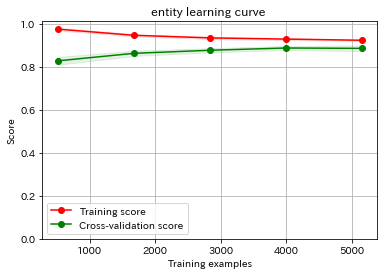

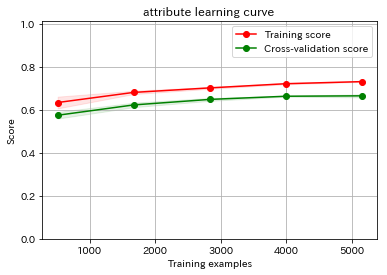

In [30]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit


# learning curve function
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(
        estimator, title, X, y, ylim=None, cv=None,
        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), verbose=0):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

for k in ["entity", "attribute"]:
    X = dataset[["context", "target", "corpus_index"]]
    if k == "entity":
        y = dataset["entity"].tolist()
        estimator = entity_model 
    else:
        y = dataset["attribute"].tolist()
        estimator = attribute_model
    
    plot_learning_curve(estimator, "{} learning curve ".format(k), 
                                         X, y, ylim=(0.0, 1.01), cv=cv, n_jobs=4, verbose=2)

plt.show()

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


X = dataset[["context", "target", "corpus_index"]]
y = dataset[["label", "entity", "attribute"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

entity_model.fit(X_train, y_train["entity"])
attribute_model.fit(X_train, y_train["attribute"])

y_true = y_test["label"].tolist()
y_pred = []
for e, a in zip(entity_model.predict(X_test), attribute_model.predict(X_test)):
    y_pred.append("{}#{}".format(e, a))

print(classification_report(y_true, y_pred))

                  precision    recall  f1-score   support

 business#amount       0.39      0.45      0.42       138
   business#cost       0.50      0.07      0.12        29
business#general       0.46      0.54      0.50       120
  business#price       0.36      0.25      0.30        16
 business#profit       0.41      0.22      0.28       209
  business#sales       0.57      0.68      0.62       430
  company#amount       0.74      0.52      0.61        27
    company#cost       1.00      0.67      0.80         3
 company#general       0.45      0.50      0.48        10
  company#profit       0.38      0.19      0.25        16
   company#sales       0.44      0.56      0.49        25
   market#amount       0.00      0.00      0.00         0
     market#cost       0.00      0.00      0.00         0
  market#general       0.97      0.59      0.73       102
   market#profit       0.00      0.00      0.00         0
    market#sales       0.00      0.00      0.00         0
  product#amo

/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
